In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras import (
    backend as K,
    losses,
    optimizers,
    layers,
    models,
    utils,
    callbacks
)

from pathlib import Path

2024-06-03 14:29:03.348434: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-03 14:29:03.471684: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-03 14:29:03.475819: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-06-03 14:29:03.475830: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [2]:
data_dir = "/home/hrcprasad/code/hrcprasad/x_ray_lewagon2024/data/Bone Break Classification"

# load the train data

train_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="training",
    shuffle=True,
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=40
)

#load the test data
validation_data = utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.1,
    subset="validation",
    color_mode="rgb",
    image_size=(256,256),
    batch_size=64,
    seed=42
)

Found 1129 files belonging to 10 classes.
Using 1017 files for training.
Found 1129 files belonging to 10 classes.
Using 112 files for validation.


2024-06-03 14:29:05.419680: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-06-03 14:29:05.419715: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-03 14:29:05.419729: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Chai-ThinkPad): /proc/driver/nvidia/version does not exist
2024-06-03 14:29:05.420001: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Inspect class names
class_names = train_data.class_names
print("Class names:", class_names)

Class names: ['Avulsion fracture', 'Comminuted fracture', 'Fracture Dislocation', 'Greenstick fracture', 'Hairline Fracture', 'Impacted fracture', 'Longitudinal fracture', 'Oblique fracture', 'Pathological fracture', 'Spiral Fracture']


In [17]:
# data preprocessing
def preprocess(img):
    img = tf.cast(img, "float32") / 255.0
    return img

train_dataset = train_data.map(lambda x, y: (preprocess(x), y))
val_dataset = validation_data.map(lambda x, y: (preprocess(x), y))

In [18]:
# get train data and labels
x_train = []
y_train = []

for images, labels in train_dataset:
    #append train data to x_train
    x_train.append(images.numpy())

    #append labels to y_train
    y_train.append(labels.numpy())

# concatenate all the batches to get the full list
x_train = np.concatenate(x_train, axis=0)
y_train = np.concatenate(y_train, axis=0)

In [19]:
# get val data and labels

x_val = []
y_val = []

for images, labels in val_dataset:
    #append train data to x_train
    x_val.append(images.numpy())

    #append labels to y_train
    y_val.append(labels.numpy())

# concatenate all the batches to get the full list
x_val = np.concatenate(x_val, axis=0)
y_val = np.concatenate(y_val, axis=0)

In [20]:
# get single batch from train data

def sample_batch(data):
    batch = data.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()

In [21]:
class_names_dict = {
    0: 'Avulsion fracture',
    1: 'Comminuted fracture',
    2: 'Fracture Dislocation',
    3: 'Greenstick fracture',
    4: 'Hairline Fracture',
    5: 'Impacted fracture',
    6: 'Longitudinal fracture',
    7: 'Oblique fracture',
    8: 'Pathological fracture',
    9: 'Spiral Fracture'
}

In [22]:
# function to display images

def display(images, n=10, size=(15,5), cmap="gray_r", as_type="float32"):
    indices = np.random.choice(len(images), n)

    num_images_per_row = 4

    num_rows = (n + num_images_per_row - 1) // num_images_per_row

    # Set up the subplots
    fig, axes = plt.subplots(num_rows, num_images_per_row, figsize=size)

    #plt.figure(figsize=size)
    for i, index in enumerate(indices):
        #plt.subplot(1, n, i+1)

        label_index = y_train[index]

        # Convert integer label to class name
        class_name = class_names_dict.get(label_index, f'Unknown Class {label_index}')

          # Calculate the position of the subplot in the grid
        row = i // num_images_per_row
        col = i % num_images_per_row

        axes[row, col].imshow(images[index].astype(as_type), cmap=cmap)
        axes[row, col].set_title(f'Class: {label_index}')
        axes[row, col].axis('off')

    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    plt.show()

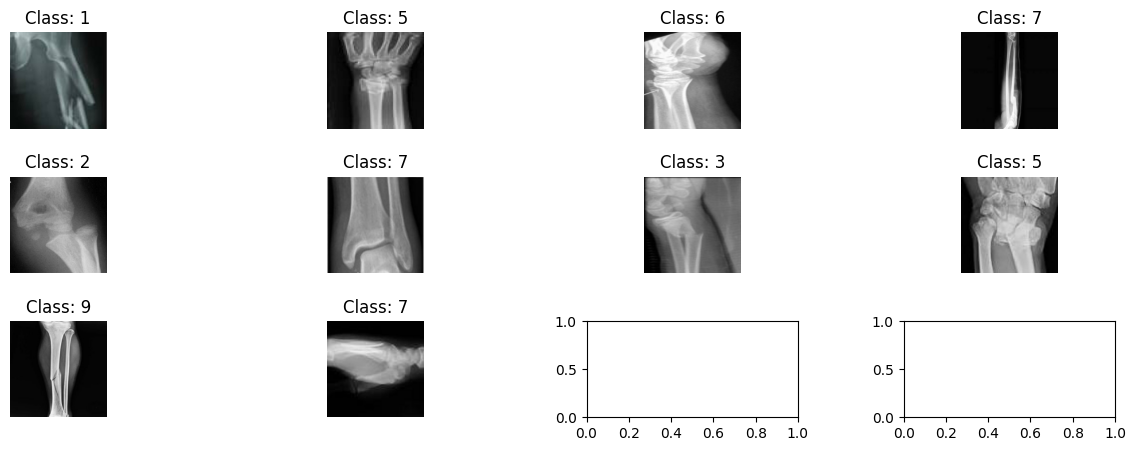

In [23]:
# display sample train images

sample_images = x_train[:100]

display(sample_images)


In [24]:
# view tensor shape

x_train.shape

(1017, 256, 256, 3)

In [25]:
# one-hot encode the train, val data

NUM_CLASSES = len(class_names)

y_train = utils.to_categorical(y_train, NUM_CLASSES)
y_val = utils.to_categorical(y_val, NUM_CLASSES)

In [26]:
input_layer = layers.Input(shape=(256, 256, 3), name="input_layer")

# Flatten to Vector before inputing in Dense Layer

x = layers.Flatten()(input_layer)

x = layers.Dense(units=300)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=250)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=200)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=150)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model = models.Model(input_layer, output_layer)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_6 (Dense)             (None, 300)               58982700  
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 300)               0         
                                                                 
 dense_7 (Dense)             (None, 250)               75250     
                                                                 
 batch_normalization_4 (Batc  (None, 250)              1000      
 hNormalization)                                                 
                                                           

In [27]:
# compile
opt = optimizers.Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

In [28]:
model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=16,
    shuffle=True
)

Epoch 1/16
32/32 [==============================] - 6s 146ms/step - loss: 2.5441 - accuracy: 0.1180
Epoch 2/16
32/32 [==============================] - 5s 148ms/step - loss: 2.1386 - accuracy: 0.2409
Epoch 3/16
32/32 [==============================] - 5s 147ms/step - loss: 1.9929 - accuracy: 0.3088
Epoch 4/16
32/32 [==============================] - 5s 159ms/step - loss: 1.8785 - accuracy: 0.3500
Epoch 5/16
32/32 [==============================] - 5s 146ms/step - loss: 1.7727 - accuracy: 0.3815
Epoch 6/16
32/32 [==============================] - 5s 158ms/step - loss: 1.6941 - accuracy: 0.4208
Epoch 7/16
32/32 [==============================] - 5s 153ms/step - loss: 1.6197 - accuracy: 0.4444
Epoch 8/16
32/32 [==============================] - 5s 145ms/step - loss: 1.4766 - accuracy: 0.5152
Epoch 9/16
32/32 [==============================] - 7s 233ms/step - loss: 1.4169 - accuracy: 0.5310
Epoch 10/16
32/32 [==============================] - 7s 218ms/step - loss: 1.3264 - accuracy: 0.5801

In [29]:
# Evaluate Model

model.evaluate(x_val, y_val)

4/4 [==============================] - 1s 54ms/step - loss: 1.2743 - accuracy: 0.6250


[1.2742925882339478, 0.625]

In [30]:
CLASSES = np.array(class_names)

preds = model.predict(x_val)

4/4 [==============================] - 0s 43ms/step


In [31]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

In [32]:
def display_preds_act(n=10, figsize=(15,3)):

    indices = np.random.choice(range(len(y_val)), n)

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(wspace=0.5, hspace=0.5)

    for i, idx in enumerate(indices):
        img = x_val[idx]
        ax = fig.add_subplot(1, n, i + 1)
        ax.axis("off")
        ax.text(0.5, -0.35, "pred = " + str(preds_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.text(0.5, -0.7, "act = " + str(actual_single[idx].split(" ")[0][:4]), fontsize=10, ha="center", transform=ax.transAxes)
        ax.imshow(img)

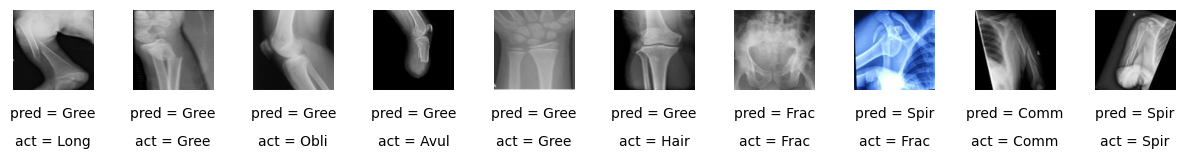

In [33]:
# predicstions with MLP
display_preds_act(n=10)

In [34]:
input_layer = layers.Input(shape=(256,256, 3))

x = layers.Conv2D(
    filters=32,
    kernel_size=(3,3),
    strides=2,
    padding="same"
)(input_layer)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    64,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    128,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Conv2D(
    256,
    3,
    strides=2,
    padding="same"
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

x = layers.Flatten()(x)

x = layers.Dense(units=100)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(rate=0.2)(x)

output_layer = layers.Dense(units=10, activation="softmax")(x)

model2 = models.Model(input_layer, output_layer)

model2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_8 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 128, 128, 32)      0         
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                           

In [35]:
opt = optimizers.Adam(learning_rate=0.0005)
model2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [36]:
# save checkpoints to monitor best performing models

model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint",
    save_weights_only = False,
    save_freq = "epoch",
    monitor = "loss",
    mode = "min",
    save_best_only = True,
    verbose = 0
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")

In [37]:
history = model2.fit(
    x_train,
    y_train,
    shuffle=True,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val),
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
    ]
)

Epoch 1/10
32/32 [==============================] - ETA: 0s - loss: 2.6091 - accuracy: 0.1839

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 29s 869ms/step - loss: 2.6091 - accuracy: 0.1839 - val_loss: 2.4922 - val_accuracy: 0.1250
Epoch 2/10
32/32 [==============================] - ETA: 0s - loss: 1.9714 - accuracy: 0.3235

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 25s 794ms/step - loss: 1.9714 - accuracy: 0.3235 - val_loss: 1.9349 - val_accuracy: 0.3304
Epoch 3/10
32/32 [==============================] - ETA: 0s - loss: 1.6819 - accuracy: 0.4100

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 31s 996ms/step - loss: 1.6819 - accuracy: 0.4100 - val_loss: 1.2208 - val_accuracy: 0.6250
Epoch 4/10
32/32 [==============================] - ETA: 0s - loss: 1.1531 - accuracy: 0.6165

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 29s 917ms/step - loss: 1.1531 - accuracy: 0.6165 - val_loss: 1.0970 - val_accuracy: 0.6964
Epoch 5/10
32/32 [==============================] - ETA: 0s - loss: 0.7521 - accuracy: 0.8004

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 30s 947ms/step - loss: 0.7521 - accuracy: 0.8004 - val_loss: 0.5324 - val_accuracy: 0.9196
Epoch 6/10
32/32 [==============================] - ETA: 0s - loss: 0.4362 - accuracy: 0.9174

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 28s 891ms/step - loss: 0.4362 - accuracy: 0.9174 - val_loss: 0.3701 - val_accuracy: 0.9375
Epoch 7/10
32/32 [==============================] - ETA: 0s - loss: 0.2617 - accuracy: 0.9656

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 29s 908ms/step - loss: 0.2617 - accuracy: 0.9656 - val_loss: 0.2996 - val_accuracy: 0.9375
Epoch 8/10
32/32 [==============================] - ETA: 0s - loss: 0.1920 - accuracy: 0.9774

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 27s 860ms/step - loss: 0.1920 - accuracy: 0.9774 - val_loss: 0.3418 - val_accuracy: 0.9375
Epoch 9/10
32/32 [==============================] - ETA: 0s - loss: 0.1430 - accuracy: 0.9843

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 29s 908ms/step - loss: 0.1430 - accuracy: 0.9843 - val_loss: 0.2333 - val_accuracy: 0.9464
Epoch 10/10
32/32 [==============================] - ETA: 0s - loss: 0.1081 - accuracy: 0.9921

INFO:tensorflow:Assets written to: ./checkpoint/assets


INFO:tensorflow:Assets written to: ./checkpoint/assets


32/32 [==============================] - 29s 901ms/step - loss: 0.1081 - accuracy: 0.9921 - val_loss: 0.2398 - val_accuracy: 0.9464


In [38]:
train_loss = history.history["loss"]
train_accuracy = history.history["accuracy"]
val_loss = history.history["val_loss"]
val_accuracy = history.history["accuracy"]

In [39]:
model2.evaluate(x_val, y_val)

4/4 [==============================] - 1s 137ms/step - loss: 0.2398 - accuracy: 0.9464


[0.23975840210914612, 0.9464285969734192]

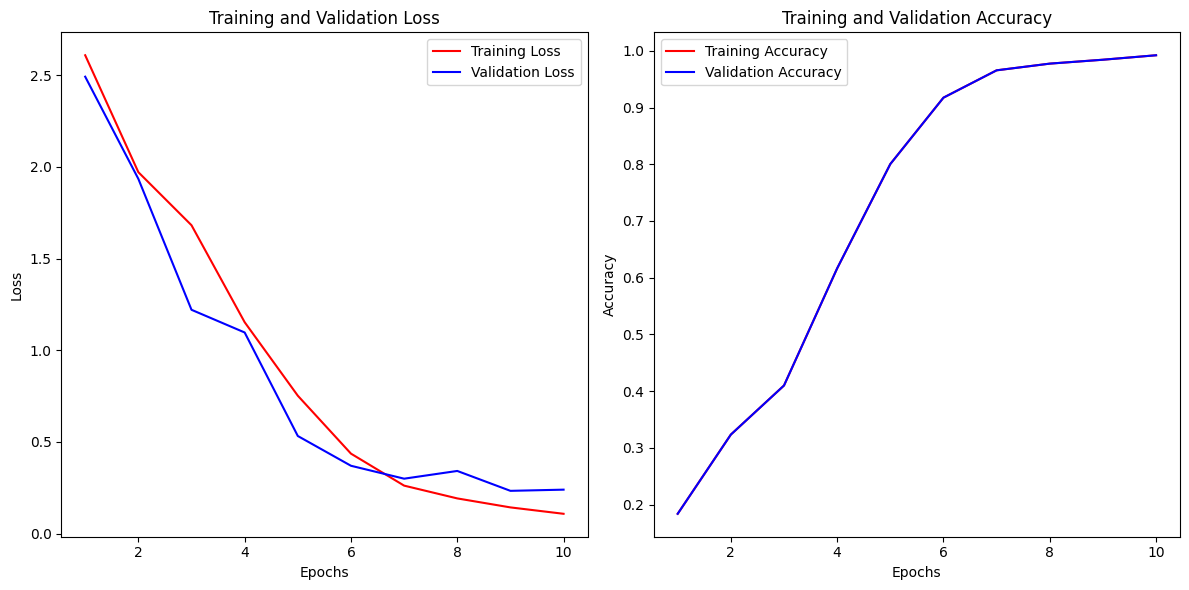

In [40]:
# plot learning curve

epochs= range(1,11)

plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'r-', label="Training Loss")
plt.plot(epochs, val_loss, 'b-', label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracy, 'r-', label="Training Accuracy")
plt.plot(epochs, val_accuracy, 'b-', label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
#predictions

preds = model2.predict(x_val)

4/4 [==============================] - 1s 145ms/step


In [42]:
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_val, axis=-1)]

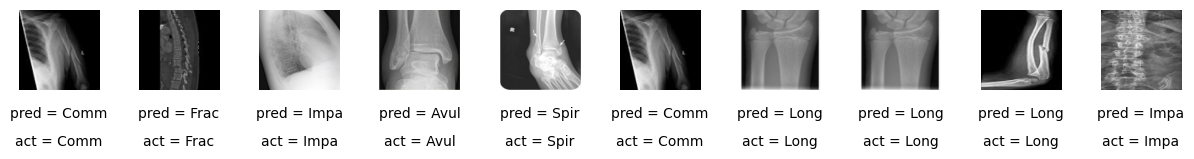

In [43]:
#Predictions

display_preds_act()